In [1]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)

import catboost
from catboost import *
from catboost import CatBoostClassifier, Pool, metrics, cv
from catboost.utils import get_roc_curve, get_confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

# other things: from sklearn.model_selection import StratifiedShuffleSplit 

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, ShuffleSplit
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, recall_score, f1_score, confusion_matrix, precision_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

import shap 

import functions 

In [2]:

best_model_params = {
    'loss_function': 'CrossEntropy', 
    'iterations': 1000,
    'depth': 4,
    'learning_rate': 0.1,
    'eval_metric': 'AUC:hints=skip_train~false',
    # 'eval_metric': metrics.AUC(),
    'custom_metric' : ['Logloss', 'Accuracy', 'AUC:hints=skip_train~false'],
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True
}


In [3]:
df = pd.read_csv('/Users/varyabazilova/Desktop/alluvial_fans/final/!!_050723_cathments_data.csv', index_col = 0)
df = df.drop(['x_wgs', 'y_wgs', 'id'], axis = 1)
df = df[df['area_m2'] > 1000]


morphometry = ['elv_median', 'elv_range', 'area_m2', 'perim_m', 'sl_median', 
               'target', 'M', 'circularity_ratio', 'compactness']

climate = ['elv_median', 'elv_range', 'area_m2', 'perim_m', 'sl_median',
           'max_annualsum_tp', 'n_rainydays_median', 'precip95', 'cross_zero',
           'frost_days', 'tp', 'snow', 'rain', 'veg_frac', 'target', 'M',
           'circularity_ratio', 'compactness', 'mean_annual_t2m_downsc',
           'cont_permafrost', 'glacier']

morphometry = df[morphometry]
climate = df[climate]


climate['glacier'] = climate['glacier'].astype(str) 
climate['cont_permafrost'] = climate['cont_permafrost'].astype(str)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##  test how bad is too bad for input data and does it matter for feature importance 


In [4]:
climate_2  = functions.invert_random_percentage(climate,'target', 2 , seed=42)
climate_5  = functions.invert_random_percentage(climate,'target', 5 , seed=42)
climate_10 = functions.invert_random_percentage(climate,'target', 10, seed=42)
climate_15 = functions.invert_random_percentage(climate,'target', 15, seed=42)
climate_20 = functions.invert_random_percentage(climate,'target', 20, seed=42)
climate_25 = functions.invert_random_percentage(climate,'target', 25, seed=42)
climate_30 = functions.invert_random_percentage(climate,'target', 30, seed=42)
climate_35 = functions.invert_random_percentage(climate,'target', 35, seed=42)
climate_40 = functions.invert_random_percentage(climate,'target', 40, seed=42)


seed = 42
test_size = 0.3

cat_features = list(['cont_permafrost', 'glacier'])


auc0 = pd.DataFrame([0.9045051521687035,
                     0.9112290494918311,
                     0.9113700116998633,
                     0.9121030151816298,
                     0.9201449091498569,
                     0.9241270915267616,
                     0.9312809235843871,
                     0.9233870399345935,
                     0.8958289282643322,
                     0.900290382148546])

accuracy0 = pd.DataFrame([0.8247232472324724,
                          0.8357933579335793,
                          0.8468634686346863,
                          0.8542435424354243,
                          0.8671586715867159,
                          0.8523985239852399,
                          0.8560885608856088,
                          0.8542435424354243,
                          0.8302583025830258,
                          0.8413284132841329])

columns = [0, 2, 5, 10, 15, 20, 25, 30, 35, 40]

n_splits = 10

In [5]:
%%time

# 2 percent 
modelC2, auc2, accuracy2 = functions.strat_split_data_make_model_save_metrics(X=climate_2.drop(columns=['target']),
                                                                            y=climate_2.target, 
                                                                            cat_features=cat_features, 
                                                                            seed = 42, n_splits=n_splits, model_params=best_model_params)

# 5 percent
modelC5, auc5, accuracy5 = functions.strat_split_data_make_model_save_metrics(X=climate_5.drop(columns=['target']),
                                                                            y=climate_5.target, 
                                                                            cat_features=cat_features, 
                                                                            seed = 42, n_splits=n_splits, model_params=best_model_params)

# 10 percent
modelC10, auc10, accuracy10 = functions.strat_split_data_make_model_save_metrics(X=climate_10.drop(columns=['target']),
                                                                              y=climate_10.target, 
                                                                              cat_features=cat_features, 
                                                                              seed = 42, n_splits=n_splits, model_params=best_model_params)

# 15 percent
modelC15, auc15, accuracy15 = functions.strat_split_data_make_model_save_metrics(X=climate_15.drop(columns=['target']),
                                                                              y=climate_15.target, 
                                                                              cat_features=cat_features, 
                                                                              seed = 42, n_splits=n_splits, model_params=best_model_params)

# 20 percent
modelC20, auc20, accuracy20 = functions.strat_split_data_make_model_save_metrics(X=climate_20.drop(columns=['target']),
                                                                              y=climate_20.target, 
                                                                              cat_features=cat_features, 
                                                                              seed = 42, n_splits=n_splits, model_params=best_model_params)
# 25 percent
modelC25, auc25, accuracy25 = functions.strat_split_data_make_model_save_metrics(X=climate_25.drop(columns=['target']),
                                                                              y=climate_25.target, 
                                                                              cat_features=cat_features, 
                                                                              seed = 42, n_splits=n_splits, model_params=best_model_params)

# 30 percent
modelC30, auc30, accuracy30 = functions.strat_split_data_make_model_save_metrics(X=climate_30.drop(columns=['target']),
                                                                              y=climate_30.target, 
                                                                              cat_features=cat_features, 
                                                                              seed = 42, n_splits=n_splits, model_params=best_model_params)

# 35 percent
modelC35, auc35, accuracy35 = functions.strat_split_data_make_model_save_metrics(X=climate_35.drop(columns=['target']),
                                                                              y=climate_35.target, 
                                                                              cat_features=cat_features, 
                                                                              seed = 42, n_splits=n_splits, model_params=best_model_params)

# 40 percent
modelC40, auc40, accuracy40 = functions.strat_split_data_make_model_save_metrics(X=climate_40.drop(columns=['target']),
                                                                              y=climate_40.target, 
                                                                              cat_features=cat_features, 
                                                                              seed = 42, n_splits=n_splits, model_params=best_model_params)




CPU times: user 3min 12s, sys: 1min 35s, total: 4min 47s
Wall time: 1min 22s


In [6]:

auc2 = pd.DataFrame(auc2)
auc5 = pd.DataFrame(auc5)
auc10 = pd.DataFrame(auc10)
auc15 = pd.DataFrame(auc15)
auc20 = pd.DataFrame(auc20)
auc25 = pd.DataFrame(auc25)
auc30 = pd.DataFrame(auc30)
auc35 = pd.DataFrame(auc35)
auc40 = pd.DataFrame(auc40)

aucsdf_clim = pd.concat([auc0, auc2,auc5, auc10,auc15,auc20,auc25,auc30,auc35, auc40], axis = 1)
aucsdf_clim.columns = columns

accuracy2 = pd.DataFrame(accuracy2)
accuracy5 = pd.DataFrame(accuracy5)
accuracy10 = pd.DataFrame(accuracy10)
accuracy15 = pd.DataFrame(accuracy15)
accuracy20 = pd.DataFrame(accuracy20)
accuracy25 = pd.DataFrame(accuracy25)
accuracy30 = pd.DataFrame(accuracy30)
accuracy35 = pd.DataFrame(accuracy35)
accuracy40 = pd.DataFrame(accuracy40)

accuracysdf_clim = pd.concat([accuracy0, accuracy2 , accuracy5, accuracy10, accuracy15,accuracy20,accuracy25,accuracy30,accuracy35,accuracy40], axis = 1)
accuracysdf_clim.columns = columns

In [8]:
morphometry_2  = functions.invert_random_percentage(morphometry,'target', 2 , seed=42)
morphometry_5  = functions.invert_random_percentage(morphometry,'target', 5 , seed=42)
morphometry_10 = functions.invert_random_percentage(morphometry,'target', 10, seed=42)
morphometry_15 = functions.invert_random_percentage(morphometry,'target', 15, seed=42)
morphometry_20 = functions.invert_random_percentage(morphometry,'target', 20, seed=42)
morphometry_25 = functions.invert_random_percentage(morphometry,'target', 25, seed=42)
morphometry_30 = functions.invert_random_percentage(morphometry,'target', 30, seed=42)
morphometry_35 = functions.invert_random_percentage(morphometry,'target', 35, seed=42)
morphometry_40 = functions.invert_random_percentage(morphometry,'target', 40, seed=42)


seed = 42
test_size = 0.3

cat_features = list([])


auc0 = pd.DataFrame([0.8775038412201689,
                     0.8822190270788401,
                     0.8869835497103227,
                     0.8776518515386025,
                     0.8930237803244951,
                     0.8880971511537756,
                     0.891571869581765,
                     0.8964491619796733,
                     0.8783214220267546,
                     0.8778632948506505])

accuracy0 = pd.DataFrame([0.8025830258302583,
                          0.8154981549815498,
                          0.8228782287822878,
                          0.8136531365313653,
                          0.8228782287822878,
                          0.8044280442804428,
                          0.8118081180811808,
                          0.8468634686346863,
                          0.8044280442804428,
                          0.8062730627306273])

columns = [0, 2, 5, 10, 15, 20, 25, 30, 35, 40]

In [9]:
%%time

# 2 percent 
modelM2, auc2, accuracy2 = functions.strat_split_data_make_model_save_metrics(X=morphometry_2.drop(columns=['target']),
                                                                            y=morphometry_2.target, 
                                                                            cat_features=cat_features, 
                                                                            seed = 42, n_splits=n_splits, model_params=best_model_params)

# 5 percent
modelM5, auc5, accuracy5 = functions.strat_split_data_make_model_save_metrics(X=morphometry_5.drop(columns=['target']),
                                                                            y=morphometry_5.target, 
                                                                            cat_features=cat_features, 
                                                                            seed = 42, n_splits=n_splits, model_params=best_model_params)

# 10 percent
modelM10, auc10, accuracy10 = functions.strat_split_data_make_model_save_metrics(X=morphometry_10.drop(columns=['target']),
                                                                              y=morphometry_10.target, 
                                                                              cat_features=cat_features, 
                                                                              seed = 42, n_splits=n_splits, model_params=best_model_params)

# 15 percent
model, auc15, accuracy15 = functions.strat_split_data_make_model_save_metrics(X=morphometry_15.drop(columns=['target']),
                                                                              y=morphometry_15.target, 
                                                                              cat_features=cat_features, 
                                                                              seed = 42, n_splits=n_splits, model_params=best_model_params)

# 20 percent
model, auc20, accuracy20 = functions.strat_split_data_make_model_save_metrics(X=morphometry_20.drop(columns=['target']),
                                                                              y=morphometry_20.target, 
                                                                              cat_features=cat_features, 
                                                                              seed = 42, n_splits=n_splits, model_params=best_model_params)
# 25 percent
model, auc25, accuracy25 = functions.strat_split_data_make_model_save_metrics(X=morphometry_25.drop(columns=['target']),
                                                                              y=morphometry_25.target, 
                                                                              cat_features=cat_features, 
                                                                              seed = 42, n_splits=n_splits, model_params=best_model_params)

# 30 percent
model, auc30, accuracy30 = functions.strat_split_data_make_model_save_metrics(X=morphometry_30.drop(columns=['target']),
                                                                              y=morphometry_30.target, 
                                                                              cat_features=cat_features, 
                                                                              seed = 42, n_splits=n_splits, model_params=best_model_params)

# 35 percent
model, auc35, accuracy35 = functions.strat_split_data_make_model_save_metrics(X=morphometry_35.drop(columns=['target']),
                                                                              y=morphometry_35.target, 
                                                                              cat_features=cat_features, 
                                                                              seed = 42, n_splits=n_splits, model_params=best_model_params)

# 40 percent
model, auc40, accuracy40 = functions.strat_split_data_make_model_save_metrics(X=morphometry_40.drop(columns=['target']),
                                                                              y=morphometry_40.target, 
                                                                              cat_features=cat_features, 
                                                                              seed = 42, n_splits=n_splits, model_params=best_model_params)




CPU times: user 2min 5s, sys: 1min 29s, total: 3min 35s
Wall time: 1min 9s


In [10]:

auc2 = pd.DataFrame(auc2)
auc5 = pd.DataFrame(auc5)
auc10 = pd.DataFrame(auc10)
auc15 = pd.DataFrame(auc15)
auc20 = pd.DataFrame(auc20)
auc25 = pd.DataFrame(auc25)
auc30 = pd.DataFrame(auc30)
auc35 = pd.DataFrame(auc35)
auc40 = pd.DataFrame(auc40)

aucsdf_morph = pd.concat([auc0, auc2,auc5, auc10,auc15,auc20,auc25,auc30,auc35, auc40], axis = 1)
aucsdf_morph.columns = columns

accuracy2 = pd.DataFrame(accuracy2)
accuracy5 = pd.DataFrame(accuracy5)
accuracy10 = pd.DataFrame(accuracy10)
accuracy15 = pd.DataFrame(accuracy15)
accuracy20 = pd.DataFrame(accuracy20)
accuracy25 = pd.DataFrame(accuracy25)
accuracy30 = pd.DataFrame(accuracy30)
accuracy35 = pd.DataFrame(accuracy35)
accuracy40 = pd.DataFrame(accuracy40)

accuracysdf_morph = pd.concat([accuracy0, accuracy2 , accuracy5, accuracy10, accuracy15,accuracy20,accuracy25,accuracy30,accuracy35,accuracy40], axis = 1)
accuracysdf_morph.columns = columns

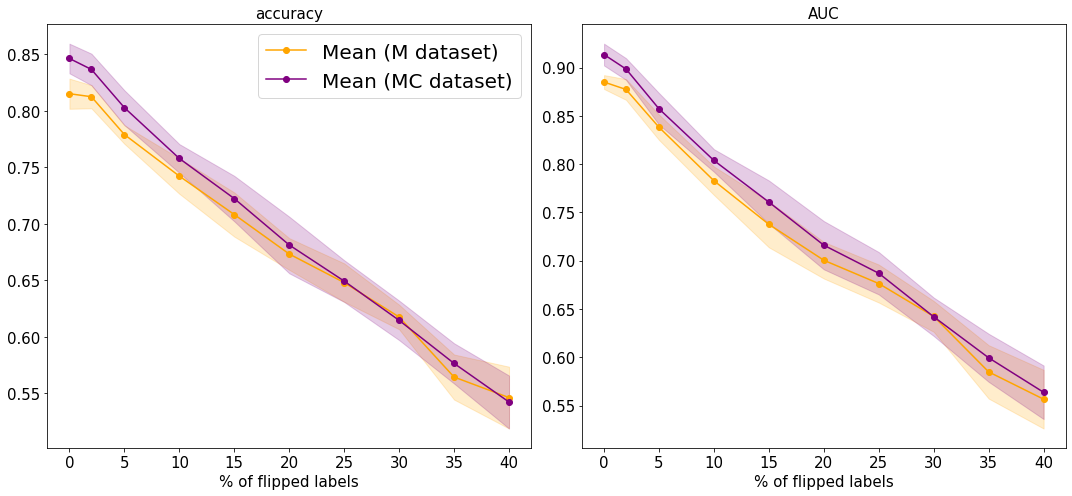

In [13]:

# MORPH 
acc_meansM = accuracysdf_morph.mean(axis=0)
acc_stdsM = accuracysdf_morph.std(axis=0)

auc_meansM = aucsdf_morph.mean(axis=0)
auc_stdsM = aucsdf_morph.std(axis=0)


# CLIM
acc_meansC = accuracysdf_clim.mean(axis=0)
acc_stdsC = accuracysdf_clim.std(axis=0)

auc_meansC = aucsdf_clim.mean(axis=0)
auc_stdsC = aucsdf_clim.std(axis=0)



accuracysdf_morph.index.name = 'split'
accuracysdf_clim.index.name = 'split'
aucsdf_morph.index.name = 'split'
aucsdf_clim.index.name = 'split'

# Plotting
fig = plt.figure(figsize=(15, 7))
mosaic = fig.subplot_mosaic('''
                            aabb
                            ''')

# morphometry ACC 

# Plot the mean line with dots
mosaic['a'].plot(accuracysdf_morph.columns, acc_meansM, marker='o', linestyle='-', color='orange', label='Mean (M dataset)')
# Plot the spread as shading
mosaic['a'].fill_between(accuracysdf_morph.columns, acc_meansM - acc_stdsM, acc_meansM + acc_stdsM, color='orange', alpha=0.2)#, label='Spread - Morphometric')

means = auc_meansM
stds = auc_stdsM
# morphometry AUC
# mosaic['b'].plot(aucsdf_morph.columns, auc_meansM, marker='o', linestyle='-', color='orange', label='Mean (dataset only incl. Morphometric parameters)')
mosaic['b'].plot(aucsdf_morph.columns, auc_meansM, marker='o', linestyle='-', color='orange', label='Mean (M dataset)')
# Plot the spread as shading
mosaic['b'].fill_between(aucsdf_morph.columns, auc_meansM - auc_stdsM, auc_meansM + auc_stdsM, color='orange', alpha=0.2)#, label='Spread')



# CLIMATE ACC 

# Plot the mean line with dots
mosaic['a'].plot(accuracysdf_clim.columns, acc_meansC, marker='o', linestyle='-', color='purple', label='Mean (MC dataset)')
# Plot the spread as shading
mosaic['a'].fill_between(accuracysdf_morph.columns, acc_meansC - acc_stdsC, acc_meansC + acc_stdsC, color='purple', alpha=0.2)#, label='Spread')

# mosaic['b'].plot([],[], marker='o', linestyle='-', color='none', label=' ')


# CLIMATE AUC
# mosaic['b'].plot(aucsdf_clim.columns, auc_meansC, marker='o', linestyle='-', color='purple', label='Mean (dataset incl. both Morphometric paramaters \n and climatic variables)')
mosaic['b'].plot(aucsdf_clim.columns, auc_meansC, marker='o', linestyle='-', color='purple', label='Mean (MC dataset)')
# Plot the spread as shading
mosaic['b'].fill_between(aucsdf_clim.columns, auc_meansC - auc_stdsC, auc_meansC + auc_stdsC, color='purple', alpha=0.2)#, label='Spread')


mosaic['a'].set_title('accuracy', fontsize = 15)
mosaic['b'].set_title('AUC', fontsize = 15)

mosaic['a'].set_xlabel('% of flipped labels', fontsize = 15)
mosaic['b'].set_xlabel('% of flipped labels', fontsize = 15)

mosaic['a'].tick_params(axis='x', labelsize=15)
mosaic['a'].tick_params(axis='y', labelsize=15)

mosaic['b'].tick_params(axis='x', labelsize=15)
mosaic['b'].tick_params(axis='y', labelsize=15)


mosaic['a'].legend(fontsize=20)


plt.tight_layout()

# plt.legend()


# plt.savefig('out/removed_points/flip_labels_both_models_spread.png', dpi = 300)